For this challenge you have two options for how to use neural networks . Choose one of the following:

<ul><li>Use RBM to perform feature extraction on an image-based dataset that you find or create. If you go this route, present the features you extract and explain why this is a useful feature extraction method in the context you’re operating in. DO NOT USE either the MNIST digit recognition database or the iris data set. They’ve been worked on in very public ways very very many times and the code is easily available. (However, that code could be a useful resource to refer to).</li> _OR_,

<li>Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!</li>

Once you've chosen which option you prefer, get to modeling and submit your work below.

In [1]:
# Import data science environment.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import sklearn 
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_style('white')

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='internal gelsd'
)

In [2]:
# Load and preview the data file.
churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


# Conversions

In [3]:
# Convert 'yes'/'no' values to '1'/'0'.
churn['Partner'] = churn['Partner'].apply(lambda x: 0 if x=='No' else 1)
churn['Dependents'] = churn['Dependents'].apply(lambda x: 0 if x=='No' else 1)
churn['PhoneService'] = churn['PhoneService'].apply(lambda x: 0 if x=='No' else 1)
churn['PaperlessBilling'] = churn['PaperlessBilling'].apply(lambda x: 0 if x=='No' else 1)
churn['Churn'] = churn['Churn'].apply(lambda x: 0 if x=='No' else 1)

# Convert 'yes'/'no'/'no service' values to '1'/'0'/'0' (since no service is the same as no).
churn['MultipleLines'].replace(('No phone service', 'No', 'Yes'), (0, 0, 1),
                               inplace=True)
churn['OnlineSecurity'].replace(('No', 'Yes', 'No internet service'),
                                (0, 1, 0), inplace=True)
churn['OnlineBackup'].replace(('Yes', 'No', 'No internet service'),
                              (1, 0, 0), inplace=True)
churn['DeviceProtection'].replace(('No', 'Yes', 'No internet service'),
                                  (0, 1, 0), inplace=True)
churn['TechSupport'].replace(('No', 'Yes', 'No internet service'), (0, 1, 0),
                             inplace=True)
churn['StreamingTV'].replace(('No', 'Yes', 'No internet service'), (0, 1, 0),
                             inplace=True)
churn['StreamingMovies'].replace(('No', 'Yes', 'No internet service'),
                                 (0, 1, 0), inplace=True)

# Covert 'DSL'/'Fiber optic'/'No' to '1'/'2'/'0' since fiber optic is fastest.
churn['InternetService'].replace(('DSL', 'Fiber optic', 'No'), (1, 2, 0),
                                 inplace=True)

# Convert to number of years.
churn['Contract'].replace(('Month-to-month', 'One year', 'Two year'),
                          (0, 1, 2), inplace=True)

# Convert 'male'/'female' to '1'/'0'.
churn['gender'].replace(('Female', 'Male'), (0, 1), inplace=True)

churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,1,Electronic check,29.850,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,1,...,1,0,0,0,1,0,Mailed check,56.950,1889.5,0
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,0,0,0,0,0,1,Mailed check,53.850,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,1,...,1,1,0,0,1,0,Bank transfer (automatic),42.300,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,2,0,...,0,0,0,0,0,1,Electronic check,70.700,151.65,1


In [4]:
# Replace empty cells (' ') with '0'.
churn['TotalCharges'] = churn['TotalCharges'].replace(' ', '0')

In [5]:
# Change dtype from object to float.
churn['TotalCharges'] = churn['TotalCharges'].astype('float64')

# Create Dummy Variables

In [6]:
# Create dummy variables for remaining categorical data.
dummy = pd.get_dummies(churn['PaymentMethod'])

# Merge dataframes together.
churn_dum = churn.merge(dummy, left_index=True, right_index=True)

# Drop 'PaymentMethod' column.
churn_dum.drop(['PaymentMethod'], axis=1)

churn_dum.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,7590-VHVEG,0,0,1,0,1,0,0,1,0,...,0,1,Electronic check,29.850,29.850,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,1,...,1,0,Mailed check,56.950,1889.500,0,0,0,0,1
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,0,1,Mailed check,53.850,108.150,1,0,0,0,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,1,...,1,0,Bank transfer (automatic),42.300,1840.750,0,1,0,0,0
4,9237-HQITU,0,0,0,0,2,1,0,2,0,...,0,1,Electronic check,70.700,151.650,1,0,0,1,0


In [7]:
# Change dtypes from 'uint8' to 'int64'.
cols_to_include = ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
for col in churn_dum.columns:
    if churn_dum[col].nunique() < 10 and col in cols_to_include:
        churn_dum[col] = churn_dum[col].astype('int64')
churn_dum.dtypes

customerID                    object
gender                         int64
SeniorCitizen                  int64
Partner                        int64
Dependents                     int64
tenure                         int64
PhoneService                   int64
MultipleLines                  int64
InternetService                int64
OnlineSecurity                 int64
OnlineBackup                   int64
DeviceProtection               int64
TechSupport                    int64
StreamingTV                    int64
StreamingMovies                int64
Contract                       int64
PaperlessBilling               int64
PaymentMethod                 object
MonthlyCharges               float64
TotalCharges                 float64
Churn                          int64
Bank transfer (automatic)      int64
Credit card (automatic)        int64
Electronic check               int64
Mailed check                   int64
dtype: object

# Separate by Target Values

In [8]:
# Create dataframe of only customers who churned.
churn_yes = churn_dum[churn_dum['Churn'] == 1]

# Create dataframe of only customers who did not churn.
churn_no = churn_dum[churn_dum['Churn'] == 0]

# Normalize Value Counts

1    3500
0    3500
Name: Churn, dtype: int64

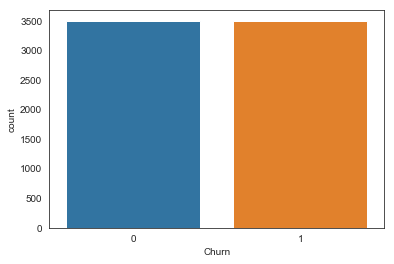

In [9]:
# Let's resample the data.
from sklearn.utils import resample

# Upsample minority class.
churn_yes = resample(churn_yes,
                     replace=True,
                     n_samples=3500,
                     random_state=15)

# Downsample majority class.
churn_no = resample(churn_no,
                    replace=True,
                    n_samples=3500,
                    random_state=15)

# Combine upsampled minority class and downsampled majority class.
churn_sampled = pd.concat([churn_yes, churn_no])

# Display new class counts.
sns.countplot('Churn', data=churn_sampled)
churn_sampled.Churn.value_counts()

# Set up Training Groups

In [10]:
# Split data into classes and training groups.
X = churn_sampled.drop(['customerID', 'PaymentMethod', 'Churn'], 1)
y = churn_sampled.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

# Multi-Layer Perceptron

### (20, 20,) hidden layers

In [11]:
# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a twenty-layer hidden layer.
mlp = MLPClassifier(hidden_layer_sizes=(20, 20,), random_state=15)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [12]:
mlp.score(X_train, y_train)

0.7363809523809524

In [13]:
y.value_counts()/len(y)

1   0.500
0   0.500
Name: Churn, dtype: float64

In [14]:
cross_val_score(mlp, X_train, y_train, cv=5)

array([0.74881066, 0.71142857, 0.74761905, 0.74952381, 0.7435653 ])

### (60,) single hidden layer

In [15]:
# Establish and fit the model, with a twenty-layer hidden layer.
mlp1 = MLPClassifier(hidden_layer_sizes=(60,), random_state=15)
mlp1.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [16]:
mlp1.score(X_train, y_train)

0.7533333333333333

In [17]:
cross_val_score(mlp1, X_train, y_train, cv=5)

array([0.69552807, 0.76190476, 0.74857143, 0.76666667, 0.65872259])

### (15, 30, 15,) hidden layers

In [18]:
# Establish and fit the model, with a twenty-layer hidden layer.
mlp2 = MLPClassifier(hidden_layer_sizes=(15, 30, 15,), random_state=15)
mlp2.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 30, 15), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [19]:
mlp2.score(X_train, y_train)

0.7582857142857143

In [20]:
cross_val_score(mlp2, X_train, y_train, cv=5)

array([0.67459562, 0.78380952, 0.7352381 , 0.73809524, 0.69304099])

It appears that the first model is the best of the three. Two hidden layers of 20 each performed the best. Let's try one more where I try to manually tune the perceptron hidden layers.

### (7, 9,) hidden layers

In [21]:
mlp3 = MLPClassifier(hidden_layer_sizes=(18,), random_state=15)
mlp3.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(18,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [22]:
mlp3.score(X_train, y_train)

0.7695238095238095

In [23]:
cross_val_score(mlp3, X_train, y_train, cv=5)

array([0.73644148, 0.78      , 0.74666667, 0.69714286, 0.72163966])

This model seems to perform just slightly better than the (20, 20,) hidden layers. I began with (1,) layer and increased until I saw significant drop-off. This occured as I moved from (7,) to (10,) hidden layers. I went back to (7,) and added a second layer (7, 1,). I proceeded to add values to the second layer until I reached (7, 9,).  When I tried to add additional values to the second layer, the model performed worse. I tried to tune the values (6, 9,), (8, 9,), etc, but none beat the combination of (7, 9,). I also tried to add a third layer, but none of the models beat (7, 9,).

Let's try to change the solver parameter to 'sgd' and see if that makes any difference.

### Solver = 'sgd'

In [24]:
mlp4 = MLPClassifier(hidden_layer_sizes=(7,9,), solver='sgd', random_state=15)
mlp4.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7, 9), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [25]:
mlp4.score(X_train, y_train)

0.4982857142857143

That didn't work well! Maybe we could try changing the alpha setting from 0.0001 to 0.05.

### Alpha = 0.05

In [26]:
mlp5 = MLPClassifier(hidden_layer_sizes=(7,9,), alpha=0.05, random_state=15)
mlp5.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7, 9), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [27]:
mlp5.score(X_train, y_train)

0.7365714285714285

In [28]:
cross_val_score(mlp5, X_train, y_train, cv=5)

array([0.74119886, 0.7952381 , 0.75809524, 0.72095238, 0.70448046])

Not bad, but still not as good as my self-tuned model. Now let's compare this against a random forest model.

# Random Forest

In [29]:
# Build the Random Forest model.
rfc = RandomForestClassifier()
# Fit the model.
rfc.fit(X_train, y_train)
print(rfc)
y_pred_rfc = rfc.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_rfc)
# Cross-validation.
rfc_score = cross_val_score(rfc, X, y, cv=10)
print('Cross-Validation Scores: {}'.format(rfc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(rfc_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_rfc))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_rfc))

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Cross-Validation Scores: [0.89571429 0.90857143 0.90142857 0.88714286 0.90857143 0.91714286
 0.91714286 0.90714286 0.90571429 0.88714286]
Averaged Cross-Validation Scores: 90.36%.
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       884
           1       0.90      0.92      0.91       866

   micro avg       0.91      0.91      0.91      1750
   macro avg       0.91      0.91      0.91      1750
weighted avg       0.91      0.91      0.91      1750

[[792  92]
 [ 70 796]]


# Comparisons

In [31]:
# Now let's run the mlp scores with the train sets and compare them with the test sets.
mlp.score(X_train, y_train)

0.7363809523809524

In [32]:
mlp.score(X_test, y_test)

0.724

In [33]:
mlp1.score(X_train, y_train)

0.7533333333333333

In [34]:
mlp1.score(X_test, y_test)

0.7588571428571429

In [35]:
mlp2.score(X_train, y_train)

0.7582857142857143

In [36]:
mlp2.score(X_test, y_test)

0.7542857142857143

In [37]:
mlp3.score(X_train, y_train)

0.7695238095238095

In [38]:
mlp3.score(X_test, y_test)

0.7674285714285715

In [39]:
mlp4.score(X_train, y_train)

0.4982857142857143

In [40]:
mlp4.score(X_test, y_test)

0.5051428571428571

In [41]:
mlp5.score(X_train, y_train)

0.7365714285714285

In [42]:
mlp5.score(X_test, y_test)

0.7274285714285714

In [43]:
rfc.score(X_train, y_train)

0.993904761904762

In [44]:
rfc.score(X_test, y_test)

0.9074285714285715

In conclusion, it appears that the mlp3 model is the best predictor with 76.95% training score and 76.74% test score. This is no comparison to the Random Forest model, which had a training score of 99.39% and a test score of 90.74%, significantly better than all mlp scores.